# Project Title
### Data Engineering Capstone Project

#### Project Summary
The project goal is to build an ETL pipeline by gathering desparate data in different sources, and transform and load to Amazon S3 cluster. In this project, I will create a clean dataset that consists of the US immigration data, US state demographics, weather information and airport data. The result dataset could be used for further analysis of identifying trends in travel and immigration to the US. 

The project follows the follow steps:
* Step 1: Scope the Project and Gather Data
* Step 2: Explore and Assess the Data
* Step 3: Define the Data Model
* Step 4: Run ETL to Model the Data
* Step 5: Complete Project Write Up

In [26]:
# Do all imports and installs here
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf, monotonically_increasing_id, date_format, col, upper, first, count, when , isnan, udf, dayofmonth, dayofweek, month, year, weekofyear
from pyspark.sql.types import StructField, StructType, StringType, LongType, IntegerType, FloatType
import datetime as dt
import utility

import seaborn as sns
import matplotlib.pyplot as plt
import os
import configparser
import plotly.plotly as py
import plotly.graph_objs as go
import requests
requests.packages.urllib3.disable_warnings()

In [27]:
spark = SparkSession \
        .builder \
        .config("spark.jars.packages", "org.apache.hadoop:hadoop-aws:2.7.0") \
        .getOrCreate()

### Step 1: Scope the Project and Gather Data

#### Scope 
In this project, I will create a clean dataset that consists of the US immigration data, US state demographics, weather information and airport data. The result dataset could be used for further analysis of identifying trends in travel and immigration to the US. I used Apache Spark to process the data. I also used Python, Pandas, Matplotlib and Pyspark. This version of the project reads and writes to local directory. However, it can easily be updated to read data from Amazon S3 and write back the processed data to Amazon S3. To do so, will need to point input_data and output_data variables to proper address on S3. Whole project can be run through this note book or etl.py.

#### Describe and Gather Data 
*I94 Immigration Data:* This data comes from the US National Tourism and Trade Office. A data dictionary is included in the workspace. This is where the data comes from. There's a sample file so you can take a look at the data in csv format before reading it all in. You do not have to use the entire dataset, just use what you need to accomplish the goal you set at the beginning of the project.

*World Temperature Data:* This dataset came from Kaggle. You can read more about it [here](https://www.kaggle.com/berkeleyearth/climate-change-earth-surface-temperature-data). I used temperature data *by State* version.

*U.S. City Demographic Data:* This data comes from OpenSoft. You can read more about it [here](https://public.opendatasoft.com/explore/dataset/us-cities-demographics/export/).

*Airport Code Table:* This is a simple table of airport codes and corresponding cities. It comes from [here](https://datahub.io/core/airport-codes#data).

In [28]:
	
# from pyspark.sql import SparkSession
# spark = SparkSession.builder.\
# config("spark.jars.packages","saurfang:spark-sas7bdat:2.0.0-s_2.11")\
# .enableHiveSupport().getOrCreate()
# df_spark =spark.read.format('com.github.saurfang.sas.spark').load('../../data/18-83510-I94-Data-2016/i94_apr16_sub.sas7bdat')


In [29]:
#write to parquet
# df_spark.write.parquet("sas_data")
# df_spark=spark.read.parquet("sas_data")

### Step 2: Explore and Assess the Data
#### Explore the Data 

#### Cleaning Steps

## Utility functions

Utility functions help the cleaning and transformation process easier.

In [30]:
# create a udf to convert date to datetime object
get_datetime = udf(lambda x: (dt.datetime(1960, 1, 1).date() + dt.timedelta(x)).isoformat() if x else None)

In [31]:
# a function to identify and display  columns with missing values in a table format 
def  view_calculate_missing_vals(df):
    # View columns with missing data
    nulls = pd.DataFrame(data= df.toPandas().isnull().sum(), columns=['values'])
    nulls = nulls.reset_index()
    nulls.columns = ['cols', 'values']

    # calculate % missing values
    nulls['% missing values'] = 100 * nulls['values']/df.count()
    return nulls[nulls['% missing values'] > 0]

In [32]:
# a function to identify and visualize columns with missing values in a dataframe
def plot_missing_vals(df):
    """Plotting missing values in a Spark dataframe
    
    Args: 
    df - A Spark dataframe
    """
    # create a dataframe with missing values count per column
    nan_count = df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).toPandas()
    
    # pivot dataframe
    nan_count = pd.melt(nan_count, var_name='Columns', value_name='values')
    
    # count total records in dataframe
    total = df.count()
    
    # add % missing values column
    nan_count['Percentage of missing values'] = 100 * nan_count['values']/total
    
    plt.rcdefaults();
    plt.figure(figsize=(5,3));
    ax = sns.barplot(x="Columns", y="Percentage of missing values", data=nan_count);
    ax.set_ylim(0, 100);
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90);
    plt.show();

In [33]:
# write a udf to parse latitude column
def parse_lat(lat):
    split_lat = lat.strip().split(',')
    return float(split_lat[0])
udf_parse_lat = udf(lambda x: parse_lat(x), FloatType())

In [34]:
# write a udf to parse longitude column
def parse_long(long):
    split_long = long.strip().split(',')
    return float(split_long[1])
udf_parse_long = udf(lambda x: parse_long(x), FloatType())

In [35]:
# write a udf to parse state column
def parse_state(state):
    return state.strip().split('-')[-1]
udf_parse_state = udf(lambda x: parse_state(x), StringType())

In [36]:
# write a function to show three rows of dataframe in Pandas
def show_in_Pandas(df):
    return df.limit(3).toPandas()

In [37]:
# define destination directory where tables will be written
output_data = 'output/'

In [38]:
# write a function to write tables in parquet
def create_table(df, partition_columns, directory_name):
    """This function creates a table from  different dimension data sources and writes
    them to destination (output_data directory) in parquet format.
    
    Args:
    df - A Spark dataframe 
    partition_columns - list of columns to use as partition key for each dimension table
    directory_name - name of the directory to place dimension table under output_data directory
    return spark dataframe representing the dimension table
    """
    # write dimension to parquet file
    df.write.parquet(output_data + directory_name, partitionBy=partition_columns, mode="overwrite")
    
    return df

## Immigration data

In [40]:
# Read in the immigration data here
immigration = spark.read.parquet("sas_data")

In [14]:
# check the count
immigration.count()

3096313

In [15]:
immigration.printSchema()

root
 |-- cicid: double (nullable = true)
 |-- i94yr: double (nullable = true)
 |-- i94mon: double (nullable = true)
 |-- i94cit: double (nullable = true)
 |-- i94res: double (nullable = true)
 |-- i94port: string (nullable = true)
 |-- arrdate: double (nullable = true)
 |-- i94mode: double (nullable = true)
 |-- i94addr: string (nullable = true)
 |-- depdate: double (nullable = true)
 |-- i94bir: double (nullable = true)
 |-- i94visa: double (nullable = true)
 |-- count: double (nullable = true)
 |-- dtadfile: string (nullable = true)
 |-- visapost: string (nullable = true)
 |-- occup: string (nullable = true)
 |-- entdepa: string (nullable = true)
 |-- entdepd: string (nullable = true)
 |-- entdepu: string (nullable = true)
 |-- matflag: string (nullable = true)
 |-- biryear: double (nullable = true)
 |-- dtaddto: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- insnum: string (nullable = true)
 |-- airline: string (nullable = true)
 |-- admnum: double (nullable = 

In [16]:
show_in_Pandas(immigration)

,cicid,i94yr,i94mon,i94cit,i94res,i94port,arrdate,i94mode,i94addr,depdate,...,entdepu,matflag,biryear,dtaddto,gender,insnum,airline,admnum,fltno,visatype
0,5748517.0,2016.0,4.0,245.0,438.0,LOS,20574.0,1.0,CA,20582.0,...,None,M,1976.0,10292016,F,None,QF,9.495387e+10,00011,B1
1,5748518.0,2016.0,4.0,245.0,438.0,LOS,20574.0,1.0,NV,20591.0,...,None,M,1984.0,10292016,F,None,VA,9.495562e+10,00007,B1
2,5748519.0,2016.0,4.0,245.0,438.0,LOS,20574.0,1.0,WA,20582.0,...,None,M,1987.0,10292016,M,None,DL,9.495641e+10,00040,B1


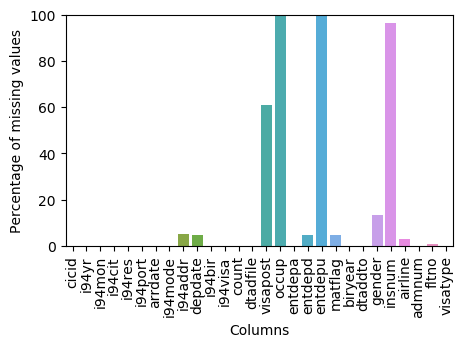

In [17]:
# visualize columns with missing values
plot_missing_vals(immigration)

`occup` and `entdepu` columns have almost 100% null values.`insnum` column has more than 90% null values. Since these columns will not be use with their null values, we will drop them. 

#### Drop columns with missing values

In [41]:
# list of columns with missing values that need to be dropped
cols = ['occup', 'entdepu', 'insnum']
# drop columns
immigration = immigration.drop(*cols)

In [19]:
# print new list of columns
immigration.columns

['cicid',
 'i94yr',
 'i94mon',
 'i94cit',
 'i94res',
 'i94port',
 'arrdate',
 'i94mode',
 'i94addr',
 'depdate',
 'i94bir',
 'i94visa',
 'count',
 'dtadfile',
 'visapost',
 'entdepa',
 'entdepd',
 'matflag',
 'biryear',
 'dtaddto',
 'gender',
 'airline',
 'admnum',
 'fltno',
 'visatype']

In [20]:
# count before dropping duplicates
immigration.count()

3096313

In [42]:
# drop duplicated records
immigration = immigration.dropDuplicates(['cicid'])

In [22]:
# count after dropping duplicates
immigration.count()

3096313

In [43]:
# drop rows with missing values
immigration = immigration.dropna(how='all', subset=['cicid'])

In [24]:
immigration.filter(col("cicid").isNull()).count()

0

There is no missing values in `cicid` column. There are no duplicate records in the dataset.

In [44]:
# rename columns to align with data model
immigration = immigration.withColumnRenamed('cicid','record_id') \
        .withColumnRenamed('i94cit','country_birth_code') \
        .withColumnRenamed('i94res', 'country_residence_code') \
        .withColumnRenamed('i94port', 'admission_port') \
        .withColumnRenamed('arrdate', 'arrival_date') \
        .withColumnRenamed('i94mode', 'transportation_mode') \
        .withColumnRenamed('i94addr', 'state_code') \
        .withColumnRenamed('depdate', 'departure_date') \
        .withColumnRenamed('i94bir', 'age') \
        .withColumnRenamed('i94visa', 'visa_code') \
        .withColumnRenamed('dtadfile', 'date_file_added') \
        .withColumnRenamed('visapost', 'visa_post') \
        .withColumnRenamed('occup', 'occupation') \
        .withColumnRenamed('entdepa', 'arrival_flag') \
        .withColumnRenamed('entdepd', 'departure_flag') \
        .withColumnRenamed('entdepu', 'update_flag') \
        .withColumnRenamed('matflag', 'match_flag') \
        .withColumnRenamed('biryear', 'birth_year') \
        .withColumnRenamed('dtaddto', 'allowed_stay_until') \
        .withColumnRenamed('gender', 'gender') \
        .withColumnRenamed('admnum', 'admission_number') \
        .withColumnRenamed('fltno', 'flight_number') \
        .withColumnRenamed('visatype', 'visa_type') \
        .withColumnRenamed('insnum', 'ins_number')  \
        .withColumnRenamed('i94yr', 'arrival_year') \
        .withColumnRenamed('i94mon', 'arrival_month')

In [45]:
# cast float data types to int and dates to datetime format
immigration = immigration.withColumn('record_id', immigration['record_id'].cast(IntegerType())) \
                        .withColumn('arrival_year', immigration['arrival_year'].cast(IntegerType())) \
                        .withColumn('arrival_month', immigration['arrival_month'].cast(IntegerType())) \
                        .withColumn('country_birth_code', immigration['country_birth_code'].cast(IntegerType())) \
                        .withColumn('country_residence_code', immigration['country_residence_code'].cast(IntegerType())) \
                        .withColumn('birth_year', immigration['birth_year'].cast(IntegerType())) \
                        .withColumn("arrival_date", get_datetime(immigration['arrival_date'])) \
                        .withColumn("departure_date", get_datetime(immigration['departure_date']))

In [27]:
show_in_Pandas(immigration)

,record_id,arrival_year,arrival_month,country_birth_code,country_residence_code,admission_port,arrival_date,transportation_mode,state_code,departure_date,...,arrival_flag,departure_flag,match_flag,birth_year,allowed_stat_until,gender,airline,admission_number,flight_number,visa_type
0,299,2016,4,103,103,NYC,2016-04-01,1.0,NY,2016-04-06,...,O,O,M,1962,06292016,None,OS,5.542587e+10,00087,WT
1,305,2016,4,103,103,NYC,2016-04-01,1.0,NY,2016-04-11,...,O,O,M,1953,06292016,None,OS,5.542582e+10,00087,WT
2,496,2016,4,103,103,CHI,2016-04-01,1.0,IL,2016-04-04,...,O,O,M,1952,06292016,None,OS,5.542862e+10,00065,WB


# US demographics data by cities

In [46]:
# Read in the US cities demographics data here
demographics = spark.read.csv('us-cities-demographics.csv', sep=';', inferSchema=True, header=True)

In [47]:
demographics.printSchema()

root
 |-- City: string (nullable = true)
 |-- State: string (nullable = true)
 |-- Median Age: double (nullable = true)
 |-- Male Population: integer (nullable = true)
 |-- Female Population: integer (nullable = true)
 |-- Total Population: integer (nullable = true)
 |-- Number of Veterans: integer (nullable = true)
 |-- Foreign-born: integer (nullable = true)
 |-- Average Household Size: double (nullable = true)
 |-- State Code: string (nullable = true)
 |-- Race: string (nullable = true)
 |-- Count: integer (nullable = true)



In [48]:
show_in_Pandas(demographics)

,City,State,Median Age,Male Population,Female Population,Total Population,Number of Veterans,Foreign-born,Average Household Size,State Code,Race,Count
0,Silver Spring,Maryland,33.8,40601,41862,82463,1562,30908,2.60,MD,Hispanic or Latino,25924
1,Quincy,Massachusetts,41.0,44129,49500,93629,4147,32935,2.39,MA,White,58723
2,Hoover,Alabama,38.5,38040,46799,84839,4819,8229,2.58,AL,Asian,4759


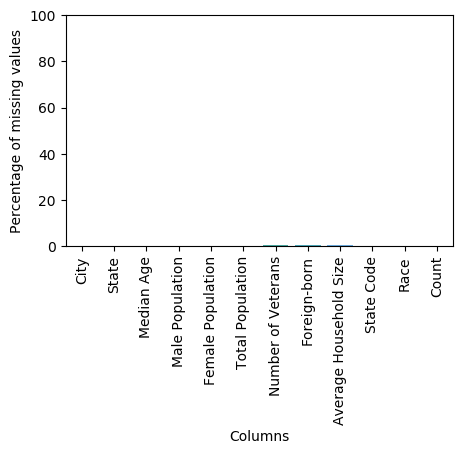

In [49]:
# plot columns with missing values
plot_missing_vals(demographics)

Missing values are nominal. We will keep columns with missing values. 

In [50]:
# visualize columns with missing values
view_calculate_missing_vals(demographics)

,cols,values,% missing values
3,Male Population,3,0.103770
4,Female Population,3,0.103770
6,Number of Veterans,13,0.449671
7,Foreign-born,13,0.449671
8,Average Household Size,16,0.553442


#### Drop columns with missing values

In [51]:
# drop rows with missing values
subset_cols = [
    'Male Population',
    'Female Population',
    'Number of Veterans',
    'Foreign-born',
    'Average Household Size'
]

In [52]:
# count before dropna
demographics.count()

2891

In [53]:
# drop rows with missing values
demographics = demographics.dropna(subset=subset_cols)

In [54]:
# count after dropna
demographics.count()

2875

In [55]:
# drop duplicated records
demographics = demographics.dropDuplicates(subset=['City', 'State', 'State Code', 'Race'])

In [56]:
# count after dropping duplicates
demographics.count()

2875

There were no duplicated records. We removed little over dozen rows with missing values. 

In [57]:
# rename columns to lower case
demographics = demographics.withColumnRenamed('City','city') \
        .withColumnRenamed('State','state') \
        .withColumnRenamed('Median Age','median_age') \
        .withColumnRenamed('Male Population', 'male_population') \
        .withColumnRenamed('Female Population', 'female_population') \
        .withColumnRenamed('Total Population', 'total_population') \
        .withColumnRenamed('Number of Veterans', 'number_of_veterans') \
        .withColumnRenamed('Foreign-born', 'foreign_born') \
        .withColumnRenamed('Average Household Size', 'avg_household_size') \
        .withColumnRenamed('State Code', 'state_code') \
        .withColumnRenamed('Race', 'race') \
        .withColumnRenamed('Count', 'count') 

# lets add an id column
demographics = demographics.withColumn('id', monotonically_increasing_id())

In [58]:
show_in_Pandas(demographics)

,city,state,median_age,male_population,female_population,total_population,number_of_veterans,foreign_born,avg_household_size,state_code,race,count,id
0,Quincy,Massachusetts,41.0,44129,49500,93629,4147,32935,2.39,MA,White,58723,0
1,Wilmington,North Carolina,35.5,52346,63601,115947,5908,7401,2.24,NC,Asian,3152,1
2,Tampa,Florida,35.3,175517,193511,369028,20636,58795,2.47,FL,Hispanic or Latino,95154,2


## Airport codes data

In [60]:
# Read in the airport data here
airport = spark.read.csv('airport-codes_csv.csv', sep=',', header=True)

In [61]:
airport.printSchema()

root
 |-- ident: string (nullable = true)
 |-- type: string (nullable = true)
 |-- name: string (nullable = true)
 |-- elevation_ft: string (nullable = true)
 |-- continent: string (nullable = true)
 |-- iso_country: string (nullable = true)
 |-- iso_region: string (nullable = true)
 |-- municipality: string (nullable = true)
 |-- gps_code: string (nullable = true)
 |-- iata_code: string (nullable = true)
 |-- local_code: string (nullable = true)
 |-- coordinates: string (nullable = true)



In [62]:
show_in_Pandas(airport)

,ident,type,name,elevation_ft,continent,iso_country,iso_region,municipality,gps_code,iata_code,local_code,coordinates
0,00A,heliport,Total Rf Heliport,11,NA,US,US-PA,Bensalem,00A,None,00A,"-74.93360137939453, 40.07080078125"
1,00AA,small_airport,Aero B Ranch Airport,3435,NA,US,US-KS,Leoti,00AA,None,00AA,"-101.473911, 38.704022"
2,00AK,small_airport,Lowell Field,450,NA,US,US-AK,Anchor Point,00AK,None,00AK,"-151.695999146, 59.94919968"


In [63]:
# count before filtering
airport.count()

55075

In [64]:
# filtering the dataset down to US airports only
airport = airport.filter("iso_country == 'US'")

In [65]:
# count after filtering
airport.count()

22757

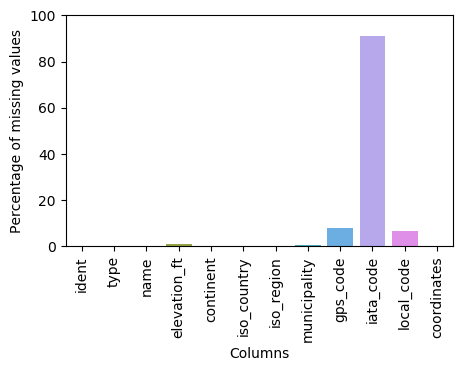

In [66]:
# visualize columns with missing values
plot_missing_vals(airport)

More than 80% of `iata_code` column is missing. We can drop this column.

#### Drop columns with missing values

In [67]:
# drop iata_code column
airport = airport.drop('iata_code')

In [68]:
# list of columns after dropping iata_code column
airport.columns

['ident',
 'type',
 'name',
 'elevation_ft',
 'continent',
 'iso_country',
 'iso_region',
 'municipality',
 'gps_code',
 'local_code',
 'coordinates']

In [69]:
# checking if ident column contains nulls
airport.filter(col("ident").isNull()).count()

0

There are no duplicated records

In [70]:
# parsing latitude, longitude and state columns
airport = airport.withColumn("airport_latitude", udf_parse_lat("coordinates")) \
                        .withColumn("airport_longitude", udf_parse_long("coordinates")) \
                        .withColumn("state", udf_parse_state("iso_region")) \
                        .withColumnRenamed("municipality", "city") \
                        .withColumnRenamed("ident", "id") \
                        .drop("coordinates", "gps_code", "local_code", "continent", "iso_region", "iso_country")

In [71]:
show_in_Pandas(airport)

,id,type,name,elevation_ft,city,airport_latitude,airport_longitude,state
0,00A,heliport,Total Rf Heliport,11,Bensalem,-74.933601,40.070801,PA
1,00AA,small_airport,Aero B Ranch Airport,3435,Leoti,-101.473907,38.704021,KS
2,00AK,small_airport,Lowell Field,450,Anchor Point,-151.695999,59.949200,AK


## Weather data

In [74]:
# read weather data here
weather = spark.read.csv('GlobalLandTemperaturesByState.csv',sep=',', header=True)

In [75]:
weather.printSchema()

root
 |-- dt: string (nullable = true)
 |-- AverageTemperature: string (nullable = true)
 |-- AverageTemperatureUncertainty: string (nullable = true)
 |-- State: string (nullable = true)
 |-- Country: string (nullable = true)



In [76]:
show_in_Pandas(weather)

,dt,AverageTemperature,AverageTemperatureUncertainty,State,Country
0,1855-05-01,25.544,1.171,Acre,Brazil
1,1855-06-01,24.228,1.103,Acre,Brazil
2,1855-07-01,24.371,1.044,Acre,Brazil


In [77]:
# count before filtering for US
weather.count()

645675

In [78]:
# filtering the data for only United States 
weather = weather.filter("Country == 'United States'")

In [79]:
# count after filtering for US
weather.count()

149745

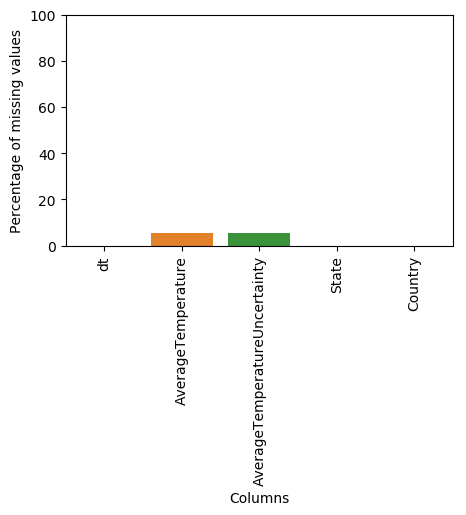

In [80]:
# visualize columns with missing values
plot_missing_vals(weather)

`AverageTemperature` and `AverageTempreatureUncertainty` columns has some missing values. However, they are less than 10%. So we keep these columns.

In [81]:
# find out percentage of columns with missing values
view_calculate_missing_vals(weather)

,cols,values,% missing values
1,AverageTemperature,7815,5.218872
2,AverageTemperatureUncertainty,7815,5.218872


In [82]:
# list of columns with null values
subset_cols = ['AverageTemperature', 'AverageTemperatureUncertainty']

In [83]:
# drop rows with missing values
weather = weather.dropna(subset=subset_cols)

In [84]:
# checking for missing values after dropping null valued rows
view_calculate_missing_vals(weather)

,cols,values,% missing values


In [85]:
# count after deleting null rows
weather.count()

141930

In [86]:
# double checking for null values 
print(weather.filter(weather.State.isNull()).count())

0


In [87]:
# rename columns to align with model, add id column and drop country column
weather = weather.withColumnRenamed('dt', 'datetime') \
                 .withColumnRenamed('AverageTemperature', 'avg_temp') \
                 .withColumnRenamed('AverageTemperatureUncertainty', 'avg_temp_uncertainty') \
                 .withColumnRenamed('State', 'state')\
                 .withColumn('id', monotonically_increasing_id()) \
                 .drop('Country')

In [88]:
show_in_Pandas(weather)

,datetime,avg_temp,avg_temp_uncertainty,state,id
0,1743-11-01,10.722000000000001,2.898,Alabama,0
1,1744-04-01,19.075,2.902,Alabama,1
2,1744-05-01,21.197,2.844,Alabama,2


It seems like the weather data gathered from 1744. Let's find out the latest date.

In [89]:
# check the latest datetime
weather.orderBy(col('datetime').desc()).show(3)

+----------+--------+--------------------+--------+-----+
|  datetime|avg_temp|avg_temp_uncertainty|   state|   id|
+----------+--------+--------------------+--------+-----+
|2013-09-01|  23.384|  0.7929999999999999| Arizona| 7415|
|2013-09-01|  17.148|               0.923|Colorado|14625|
|2013-09-01|  24.754|               1.125|Arkansas|10324|
+----------+--------+--------------------+--------+-----+
only showing top 3 rows



Since 2013 data is the closest to other data gathered (immigration 2016), we will filter weather dataset to only 2013 data.

In [90]:
# creating a year column based on datetime column
weather = weather.withColumn('year', year('datetime')) \
                .withColumn('month', month('datetime'))
show_in_Pandas(weather)

,datetime,avg_temp,avg_temp_uncertainty,state,id,year,month
0,1743-11-01,10.722000000000001,2.898,Alabama,0,1743,11
1,1744-04-01,19.075,2.902,Alabama,1,1744,4
2,1744-05-01,21.197,2.844,Alabama,2,1744,5


In [91]:
# filtering the dataset for 2013 data based on year column and dropping year column since we won't need it anymore
weather = weather.filter("year = 2013").drop('year')
show_in_Pandas(weather)

,datetime,avg_temp,avg_temp_uncertainty,state,id,month
0,2013-01-01,10.284,0.241,Alabama,3110,1
1,2013-02-01,9.161,0.213,Alabama,3111,2
2,2013-03-01,10.226,0.158,Alabama,3112,3


In [92]:
# checking the number of months covered in 2013 weather data
weather.select('month').distinct().limit(12).toPandas()

,month
0,1
1,6
2,3
3,5
4,9
5,4
6,8
7,7
8,2


It seems like 2013 data is not available for all months in 2013.

In [93]:
show_in_Pandas(weather)

,datetime,avg_temp,avg_temp_uncertainty,state,id,month
0,2013-01-01,10.284,0.241,Alabama,3110,1
1,2013-02-01,9.161,0.213,Alabama,3111,2
2,2013-03-01,10.226,0.158,Alabama,3112,3


### Time table

I will create time table based on the immigration dataframe\'s `arrival_date` column.

In [95]:
# create initial time df from immigration table arrival_date column
time = immigration.select(['arrival_date']).distinct()

In [96]:
show_in_Pandas(time)

,arrival_date
0,2016-04-22
1,2016-04-15
2,2016-04-18


In [97]:
# expand df by adding other time columns
time = time.withColumn('arrival_day', dayofmonth('arrival_date')) \
        .withColumn('arrival_week', weekofyear('arrival_date')) \
        .withColumn('arrival_month', month('arrival_date')) \
        .withColumn('arrival_year', year('arrival_date')) \
        .withColumn('arrival_weekday', dayofweek('arrival_date')) \
        .withColumn('id', monotonically_increasing_id())

In [98]:
show_in_Pandas(time)

,arrival_date,arrival_day,arrival_week,arrival_month,arrival_year,arrival_weekday,id
0,2016-04-22,22,16,4,2016,6,8589934592
1,2016-04-15,15,15,4,2016,6,25769803776
2,2016-04-18,18,16,4,2016,2,42949672960


### Step 3: Define the Data Model
#### 3.1 Conceptual Data Model
For my data model, I have chonse the Star Schema, where immigration table will serve as a fact table and all other dimension tables share common key with immigration table. I chose the Star Schema because it makes the query performance faster and easier for data analyst to work with. 

Demographics dimension table is connected to immigration table through `state_code` column. Airport dimension table is connected to immigration table through `state_code` column. Time dimension table is connected to immigration table trough `arrival_date` column. 

Weather dimension table is connected to immigration table through `state` column. Initially, I used 'GlobalWeatherTrendsByCity' data. However, I realized that I would not be able to connect the weather data with the fact table. Immigration and weather by city data did not share a common key. The second potential option was to use a Snowflake Schema to connect city with city column in Airport or Demographics data. However, this option was not practical either. Weather by city data did not have state column. This would make it impossible to identify a city, as there are many city names are repeated within different states. 


#### 3.2 Mapping Out Data Pipelines
A list steps necessary to pipeline the data into the chosen data model

1. Turn on Spark
2. Load immigration data
2. Clean immigration data
3. Create a table and write immigration data to destination in parquet format
4. Check for data quality in immigration table
5. Load demographics data
6. Clean demographics data
7. Create a table and write demographics data to destination in parquet format
8. Chek for data quality in demographics data
9. Load airport data
10. Clean airport data
11. Create a table and write airport data to destination in parquet format
12. Check for data quality in airport data
13. Load weather data
14. Clean weather data
15. Create a table and write weather data to destination in parquet format
16. Check for data quality in weather data
17. Load immigration data
18. Create time dataframe based on immigration table\'s arrival_date column
19. Create a table and write time data to destination in parquet format
20. Check for data quality in time data

### Step 4: Run Pipelines to Model the Data 
#### 4.1 Create the data model
Build the data pipelines to create the data model.

In [149]:
# create and write immigration_dim table to output data in parquet format
immigration_fact = create_table(immigration,['arrival_year', 'arrival_month'], 'immigration')

In [150]:
# create and write demographics_dim table to output data in parquet format
demographics_dim = create_table(demographics,['state_code', 'city'], 'demographics')

In [151]:
# create and write airport_dim table to output data in parquet format
airport_dim = create_table(airport, ['state', 'city'], 'aiport')

In [152]:
# create and write weather_dim table to output data in parquet format
weather_dim = create_table(weather, ['month', 'state'], 'weather')

In [153]:
# create and write time_dim table to output data in parquet format
time_dim = create_table(time, ['arrival_year', 'arrival_month', 'arrival_week'], 'time')

The same process, in more optimazed format is provided in `etl.py` file in this directory.

#### 4.2 Data Quality Checks
Data Completeness is on of the important data quality checks. Completeness includes data quality check for the count of the dataset/table. 
In this section below, I provide a code to check if my tables contain data records. 
 
Run Quality Checks

In [147]:
# Perform quality checks here
def quality_checks(df, table):
    """Count checks on fact and dimension table to ensure completeness of data.
    Args:
    df - A Spark dataframe to check row counts 
    table - corresponding name of table
    """
    total_count = df.count()

    if total_count == 0:
        print(f"Data quality check failed for {table} with zero records.")
    else:
        print(f"Data quality check passed for {table} with {total_count:,} records.")
    return 0

In [155]:
dfs = {
    'immigration_fact': immigration_fact,
    'demographics_dim': demographics_dim,
    'airport_dim': airport_dim,
    'weather_dim': weather_dim,
    'time_dim': time_dim
}
for table, df in dfs.items():
    # quality check for each table
    quality_checks(df, table)

Data quality check passed for immigration_fact with 3,096,313 records.
Data quality check passed for demographics_dim with 2,875 records.
Data quality check passed for airport_dim with 22,757 records.
Data quality check passed for weather_dim with 457 records.
Data quality check passed for time_dim with 30 records.


#### 4.3 Data dictionary 
Below is a data dictionary for my data model. For each field, I provided a brief description of what the data is and where it came from. 

*Immigration - fact table* - Data comes from he [US National Tourism and Trade Office](https://travel.trade.gov/research/reports/i94/historical/2016.html).
- record_id: Immigration record id
- arrival_year: Arrival date of visitors
- arrival_month: Arrival month
- country_birth_code: Birth country of visitors- defined in country codes
- country_residence_code: Residency country of visitors - defined in country codes
- admission_port: Port that admitted visitors
- arrival_date: Arrival date
- transportation_mode: Type of transportation used to arrive to the US
- state_code: State a visitor visiting
- age: Age of visitors
- visa_code: Visa code
- count: Aggerate count
- date_file_added: Date when the i94 added to the files
- visa_post: Port that issued visa 
- arrival_flag: Admitted or paroled into the U.S.
- departure_flag: Departed, lost I-94 or is deceased
- match_flag: Either apprehended, overstayed, adjusted to perm residence
- birth_year: Year of visitors births
- allowed_stay_until: Date until a visitor allowed to stay in the US
- gender: Gender of visitor
- airline: Airline used to arrive to the US
- admission_number: Admission number
- flight_number: Flight number taken to arrive to the US
- visa_type: Type of visa a visitor arrived to the US with

*Demographics - dimension table* - Data comes from [OpenSoft](https://public.opendatasoft.com/explore/dataset/us-cities-demographics/export/).
- id: Unique id
- city: Name of a US city
- state: Name of a US state
- median_age: Median age in a particular US city
- male_population: Number of male population
- female_population: Number of female population
- total_population: Number of total population
- number_of_veterans: Number of veterans
- foreign_born: Number of city residents born in a foreign country
- avg_household_size: Size of average household in a particular US city
- state_code: Two letter abbreviation used for US states
- race: Race of city residents
- count: Aggregate count

*Airport - dimension table*
- id: Unique id
- type: Type of an airport
- name: Name of an airport
- elevation_ft: Elevation of an airport measured in US feet
- city: Name of a city where an airport is located
- airport_latitude: Latitude coordinates
- airport_longitude: Longitude coordinates
- state: State where an airport is located

*Weather - dimension table* - Data comes from [Kaggle](https://www.kaggle.com/berkeleyearth/climate-change-earth-surface-temperature-data).
- datetime: Date when the weather recorded
- avg_temp: Average temperatures for a given US state
- avg_temp_uncertainty: Average temperature uncertainty for a given US state
- state: US state name
- id: Unique id
- month: Month when the weather recorded

*Time - dimension table* - This dimension is created based on immigration data\'s `arrival_date` column
- id: Unique id
- arrival_date: date of arrival
- arrival_day: Day of arrival 
- arrival_week: Week of arrival 
- arrival_month: Month of arrivel 
- arrival_year: Year of arrival
- arrival_weekday: Week day of arrival

#### Step 5: Complete Project Write Up
* Clearly state the rationale for the choice of tools and technologies for the project.
> I used Apache spark, because:
   - a) it is fast to process big data;
   - b) it can work well with different types of data formats.

* Propose how often the data should be updated and why.
> Documentation for the immigration data states that it is updated every month. For our database to stay up to date, it needs to be updated every month.
* Write a description of how you would approach the problem differently under the following scenarios:
 * The data was increased by 100x.
 > Spark is used precisely to support such scale out scenarious. We would need to increase Spark cluster nodes to support faster processing.This would increase the associated costs as well. 
 * The data populates a dashboard that must be updated on a daily basis by 7am every day.
 > In such cases, automated flow applications will need to be used to schedule jobs, such as Apache Airflow and others.
 * The database needed to be accessed by 100+ people.
 > In such cased, it would be better to bulk copy the datasets to Amazon Redshift or similar services, where massive paralellism is supported for 100+ queries. 